In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
inp = '/kaggle/input/lung-disease-5-class'
os.listdir(inp)

['viral_pneumonia', 'tuberculosis', 'normal', 'covid19', 'bacterial_pneumonia']

In [3]:
input_dir = '/kaggle/input/lung-disease-5-class'
output_dir = '/kaggle/working/lung disease'

shutil.copytree(input_dir, output_dir)

print("Isi dari direktori output:")
print(os.listdir(output_dir))

Isi dari direktori output:
['viral_pneumonia', 'covid19', 'bacterial_pneumonia', 'tuberculosis', 'normal']


In [4]:
classes = ['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']
inp2 = '/kaggle/working/lung disease'

lungdisease_dir = os.path.join(inp2, 'lungdisease')
os.makedirs(lungdisease_dir, exist_ok=True)

train_dir = os.path.join(lungdisease_dir, 'train_dir')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(lungdisease_dir, 'test_dir')
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(inp2, class_name)
    files = os.listdir(class_dir)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dest)
        
    for file in test_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dest)

print("Berhasil.")


Berhasil.


In [5]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

print("Jumlah gambar untuk setiap kelas di train_dir:")
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

print("\nJumlah gambar untuk setiap kelas di test_dir:")
for class_name in classes:
    class_path = os.path.join(test_dir, class_name)
    num_files = len(os.listdir(class_path))
    print(f"{class_name}: {num_files} gambar")

Jumlah gambar untuk setiap kelas di train_dir:
bacterial_pneumonia: 820 gambar
covid19: 843 gambar
normal: 835 gambar
tuberculosis: 560 gambar
viral_pneumonia: 862 gambar

Jumlah gambar untuk setiap kelas di test_dir:
bacterial_pneumonia: 206 gambar
covid19: 211 gambar
normal: 209 gambar
tuberculosis: 140 gambar
viral_pneumonia: 216 gambar


In [6]:
train_dir = os.path.join(inp2, 'lungdisease', 'train_dir')
test_dir = os.path.join(inp2, 'lungdisease', 'test_dir')

total_train_data = sum([len(files) for _, _, files in os.walk(train_dir)])

total_test_data = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Total data pada train_dir: {total_train_data}")
print(f"Total data pada test_dir: {total_test_data}")

Total data pada train_dir: 3920
Total data pada test_dir: 982


In [7]:
#augmentasi gambar
base = '/kaggle/working/lung disease/lungdisease'
#inp2 = '/kaggle/working/lung disease'
class_name = ["bacterial_pneumonia", "covid19", "normal", "tuberculosis", "viral_pneumonia"]
for img_class in class_name:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    aug_images = 1200

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 820 images belonging to 1 classes.
Found 843 images belonging to 1 classes.
Found 835 images belonging to 1 classes.
Found 560 images belonging to 1 classes.
Found 862 images belonging to 1 classes.


In [8]:
#menghitung total kelas setelah augmentasi pada train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("Banyak gambar per kelas pada train_df setelah augmentasi:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
viral_pneumonia: 1212 images
covid19: 1243 images
bacterial_pneumonia: 1220 images
tuberculosis: 1170 images
normal: 1235 images


In [15]:
train_path = '/kaggle/working/lung disease/lungdisease/train_dir'
test_path = '/kaggle/working/lung disease/lungdisease/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [16]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [17]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = True

In [18]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(100, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(100, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10035300  
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [20]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 95s 207ms/step - loss: 0.5960 - acc: 0.7962 - val_loss: 0.2744 - val_acc: 0.9246
Epoch 2/30
380/380 [==============================] - 77s 202ms/step - loss: 0.2705 - acc: 0.9138 - val_loss: 0.1613 - val_acc: 0.9552
Epoch 3/30
380/380 [==============================] - 77s 202ms/step - loss: 0.1714 - acc: 0.9488 - val_loss: 0.2394 - val_acc: 0.9399
Epoch 4/30
380/380 [==============================] - 77s 202ms/step - loss: 0.1408 - acc: 0.9553 - val_loss: 0.1551 - val_acc: 0.9572
Epoch 5/30
380/380 [==============================] - 77s 202ms/step - loss: 0.0801 - acc: 0.9738 - val_loss: 0.1952 - val_acc: 0.9521
Epoch 6/30
380/380 [==============================] - 77s 202ms/step - loss: 0.0821 - acc: 0.9755 - val_loss: 0.0946 - val_acc: 0.9786
Epoch 7/30
380/380 [==============================] - 77s 202ms/step - loss: 0.0597 - acc: 0.9816 - val_loss: 0.2068 - val_acc: 0.9440
Epoch 8/30
380/380 [==============================] - 7

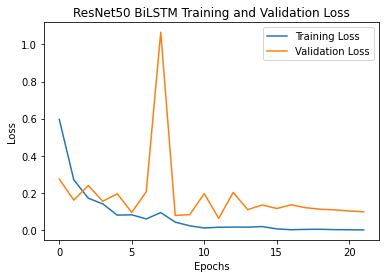

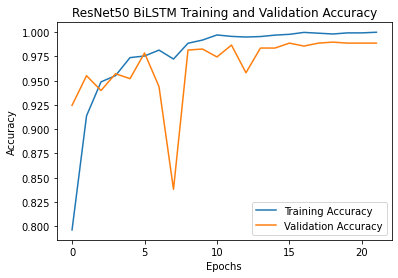

In [21]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 45ms/step - loss: 0.0628 - acc: 0.9868


In [23]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 6s 41ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   0.97573   0.98771       206
            covid19    0.99043   0.98104   0.98571       211
             normal    0.98095   0.98565   0.98329       209
       tuberculosis    0.98592   1.00000   0.99291       140
    viral_pneumonia    0.97727   0.99537   0.98624       216

           accuracy                        0.98676       982
          macro avg    0.98691   0.98756   0.98717       982
       weighted avg    0.98688   0.98676   0.98676       982



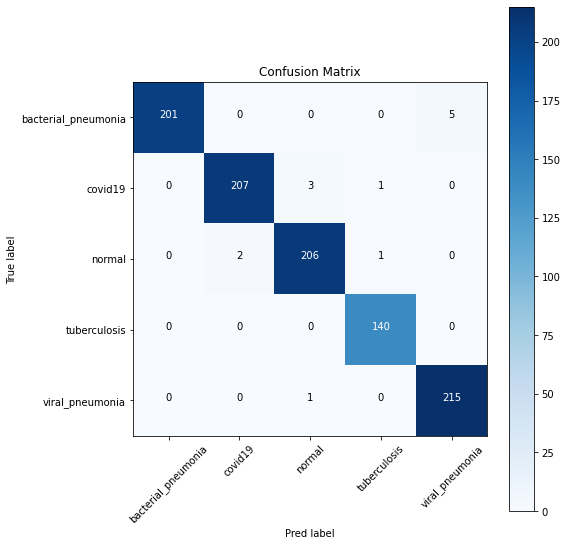

In [24]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [25]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 26s 69ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   0.98852   0.99423      1220
            covid19    0.99839   0.99598   0.99718      1243
             normal    0.98800   1.00000   0.99396      1235
       tuberculosis    0.99574   1.00000   0.99787      1170
    viral_pneumonia    0.99669   0.99422   0.99546      1212

           accuracy                        0.99572      6080
          macro avg    0.99576   0.99575   0.99574      6080
       weighted avg    0.99575   0.99572   0.99572      6080



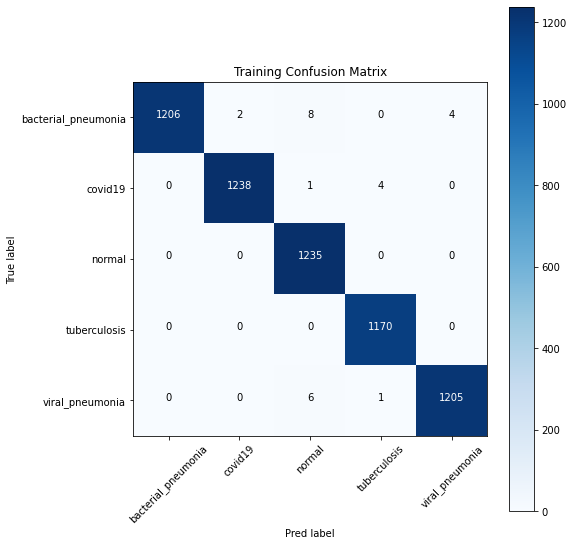

In [26]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [27]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [28]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = True

80150528/80134624 [==============================] - 1s 0us/step


In [29]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(100, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(100, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [30]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 114s 282ms/step - loss: 1.0413 - acc: 0.5998 - val_loss: 0.3342 - val_acc: 0.8982
Epoch 2/30
380/380 [==============================] - 103s 271ms/step - loss: 0.4895 - acc: 0.8173 - val_loss: 0.2192 - val_acc: 0.9287
Epoch 3/30
380/380 [==============================] - 103s 271ms/step - loss: 0.3478 - acc: 0.8717 - val_loss: 0.1497 - val_acc: 0.9430
Epoch 4/30
380/380 [==============================] - 103s 271ms/step - loss: 0.2426 - acc: 0.9155 - val_loss: 0.1126 - val_acc: 0.9593
Epoch 5/30
380/380 [==============================] - 103s 271ms/step - loss: 0.2086 - acc: 0.9280 - val_loss: 0.0936 - val_acc: 0.9695
Epoch 6/30
380/380 [==============================] - 103s 271ms/step - loss: 0.1638 - acc: 0.9434 - val_loss: 0.0930 - val_acc: 0.9654
Epoch 7/30
380/380 [==============================] - 103s 271ms/step - loss: 0.1194 - acc: 0.9569 - val_loss: 0.1376 - val_acc: 0.9501

Epoch 00007: ReduceLROnPlateau reducing learnin

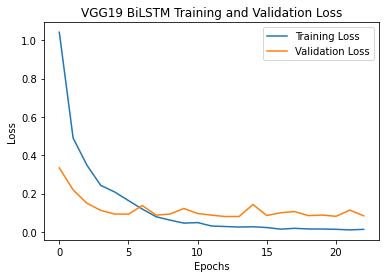

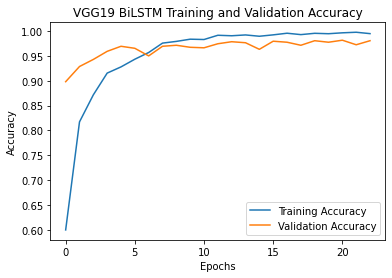

In [31]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 63ms/step - loss: 0.0805 - acc: 0.9786


In [33]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 59ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.98537   0.98058   0.98297       206
            covid19    0.97642   0.98104   0.97872       211
             normal    0.98522   0.95694   0.97087       209
       tuberculosis    0.98582   0.99286   0.98932       140
    viral_pneumonia    0.96380   0.98611   0.97483       216

           accuracy                        0.97862       982
          macro avg    0.97932   0.97951   0.97934       982
       weighted avg    0.97873   0.97862   0.97860       982



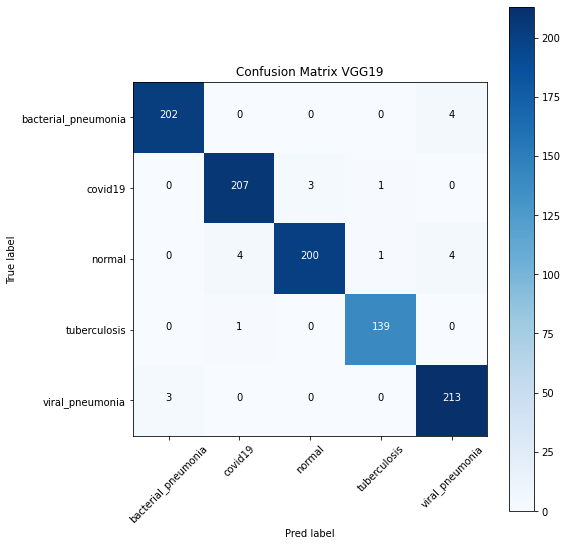

In [34]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [35]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 33s 86ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   0.99918   0.99959      1220
            covid19    1.00000   0.99839   0.99919      1243
             normal    0.99838   1.00000   0.99919      1235
       tuberculosis    1.00000   1.00000   1.00000      1170
    viral_pneumonia    0.99918   1.00000   0.99959      1212

           accuracy                        0.99951      6080
          macro avg    0.99951   0.99951   0.99951      6080
       weighted avg    0.99951   0.99951   0.99951      6080



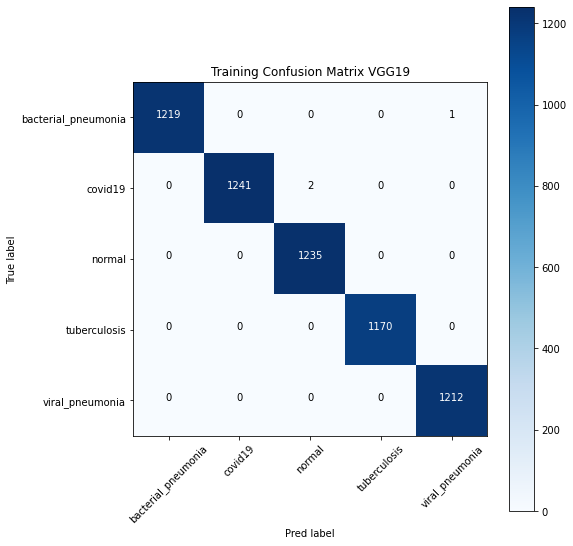

In [36]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [37]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [38]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 0s 0us/step


In [39]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(100, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(100, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5120100   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [40]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 68s 154ms/step - loss: 1.4240 - acc: 0.3817 - val_loss: 1.0454 - val_acc: 0.6344
Epoch 2/30
380/380 [==============================] - 55s 145ms/step - loss: 1.1487 - acc: 0.5322 - val_loss: 0.8225 - val_acc: 0.7230
Epoch 3/30
380/380 [==============================] - 55s 145ms/step - loss: 0.9836 - acc: 0.6000 - val_loss: 0.7044 - val_acc: 0.7505
Epoch 4/30
380/380 [==============================] - 55s 145ms/step - loss: 0.8992 - acc: 0.6495 - val_loss: 0.6298 - val_acc: 0.7790
Epoch 5/30
380/380 [==============================] - 55s 145ms/step - loss: 0.8223 - acc: 0.6798 - val_loss: 0.5783 - val_acc: 0.7882
Epoch 6/30
380/380 [==============================] - 55s 145ms/step - loss: 0.7876 - acc: 0.6977 - val_loss: 0.5480 - val_acc: 0.8014
Epoch 7/30
380/380 [==============================] - 55s 145ms/step - loss: 0.7332 - acc: 0.7081 - val_loss: 0.5135 - val_acc: 0.8035
Epoch 8/30
380/380 [==============================] - 5

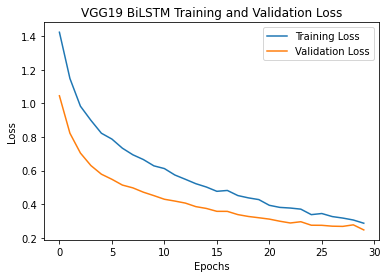

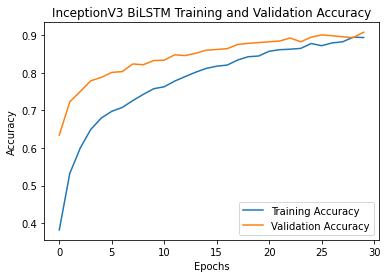

In [41]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 39ms/step - loss: 0.2464 - acc: 0.9084


In [43]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 6s 39ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.92188   0.85922   0.88945       206
            covid19    0.91549   0.92417   0.91981       211
             normal    0.91089   0.88038   0.89538       209
       tuberculosis    0.96479   0.97857   0.97163       140
    viral_pneumonia    0.85408   0.92130   0.88641       216

           accuracy                        0.90835       982
          macro avg    0.91343   0.91273   0.91254       982
       weighted avg    0.90937   0.90835   0.90828       982



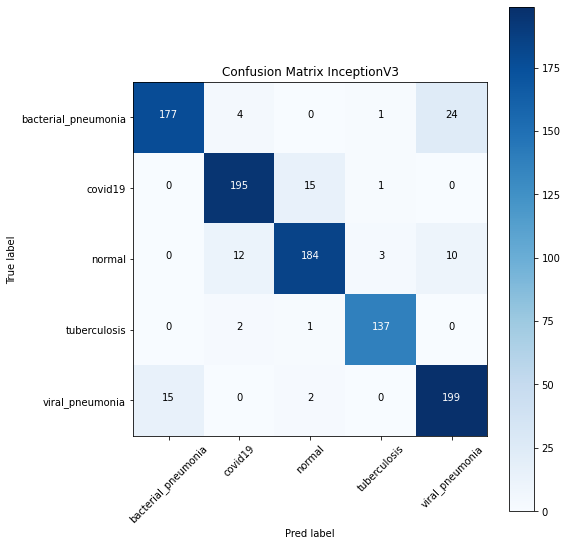

In [44]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [45]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 22s 59ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.97395   0.95000   0.96183      1220
            covid19    0.96586   0.93323   0.94926      1243
             normal    0.94165   0.95385   0.94771      1235
       tuberculosis    0.97727   0.99231   0.98473      1170
    viral_pneumonia    0.94240   0.97195   0.95695      1212

           accuracy                        0.95987      6080
          macro avg    0.96023   0.96027   0.96009      6080
       weighted avg    0.96008   0.95987   0.95982      6080



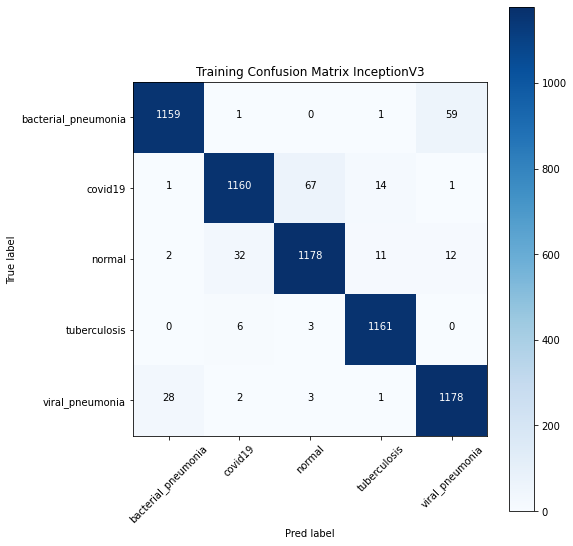

In [46]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()